In [1]:
import os
import glob
import csv
import sys
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from darts import TimeSeries
from darts.models import AutoARIMA
from darts.metrics import mae
from darts.utils.missing_values import fill_missing_values

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [3]:
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

In [4]:
os.getcwd()

'/home/nazim/MAIN4/projetindus2/Code/700-300'

In [5]:
!ls

darts_logs
Projet_bourse_300.ipynb
Projet_climat_300.ipynb
Projet_données_démographiques_300.ipynb
Projet_energie_gaz_eau_electricité_300.ipynb
Projet_maladies_300.ipynb
Sarima_bourse_300.ipynb
Sarima_climat_300.ipynb
Sarima_données_demographiques_300.ipynb
Sarima_energie_gaz_eau_electricité_300.ipynb
Sarima_maladies_300.ipynb
Transformers_bourse.ipynb
Transformers_climat.ipynb
Transformers_données_démographiques.ipynb
Transformers_energie_gaz_eau_electricité.ipynb
Transformers_maladies.ipynb


In [6]:
os.chdir('../../Datasets/Bourse')
os.getcwd()

'/home/nazim/MAIN4/projetindus2/Datasets/Bourse'

In [7]:
def interpolate_method(df,column_name,methode,direction,order,limit):
  df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
  return df

def clean_csv(df,time_variable,quantitative_variable):
  df = df[[time_variable, quantitative_variable]].copy()
  df.columns = ['ds','y']
  df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
  df = df.drop_duplicates(subset=['ds'])
  df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
  df = df.dropna(subset=['ds'])
  df = df.sort_values(by=['ds'])
  pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
  if(pourcentage < 25):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
  elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
  if(len(df) > 1000):
      supr = len(df) - 1000
      df = df[:-supr]
  return df, pourcentage

In [10]:
def simul():
    file_name = []
    df = []
    pourcentage = []

    series_scaled_list= []
    val_scaled_list = []
    pred_series_list= []
    error_results = pd.DataFrame(columns=['DATA_SET_NAME','MAE','MSE','RMSE'])
    i = 0
    
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "ds","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)

        series = TimeSeries.from_dataframe(df_clean, 'ds', 'y')

        train, val = series[:-300], series[-300:]

        scaler = Scaler()
        train_scaled = scaler.fit_transform(train)
        val_scaled = scaler.transform(val)
        series_scaled = scaler.transform(series)
        print("the {} dataset has {} data points".format(file_name[i],len(series)))
        
        series_scaled_list.append(series_scaled)
        val_scaled_list.append(val_scaled)
        
        model = AutoARIMA()
        model.fit(train_scaled)
        pred_series = model.predict(len(val))
        
        pred_series_list.append(pred_series)
        
        df_new_row_error = pd.DataFrame(data=np.array([[file_name[i],mae(pred_series, val_scaled), mse(pred_series, val_scaled), rmse(pred_series, val_scaled)]]), columns=['DATA_SET_NAME','MAE','MSE','RMSE'])
        error_results = pd.concat([error_results,df_new_row_error], ignore_index=True)
        i = i +1

    return file_name, df, series_scaled_list, val_scaled_list, pred_series_list, error_results

In [11]:
file_name, df, series_scaled_list, val_scaled_list, pred_series_list, error_results = simul()

D-ZEC_USDT
the D-ZEC_USDT dataset has 1000 data points
D-ltc
the D-ltc dataset has 1000 data points
D-ETC_USDT
the D-ETC_USDT dataset has 1000 data points
D-TRX_USDT
the D-TRX_USDT dataset has 1000 data points
D-bitcoin
the D-bitcoin dataset has 1000 data points
D-eos
the D-eos dataset has 1000 data points
D-neo
the D-neo dataset has 1000 data points
D-eth
the D-eth dataset has 1000 data points
D-link
the D-link dataset has 1000 data points
D-bnb
the D-bnb dataset has 1000 data points
D-ADA_USDT
the D-ADA_USDT dataset has 1000 data points
D-xrp
the D-xrp dataset has 1000 data points
D-XLM_USDT
the D-XLM_USDT dataset has 1000 data points


In [12]:
error_results.to_csv(r'../../Resultats/Resultats_300/Sarima_results_bourse.csv', index = False)

In [13]:
print(error_results)

   DATA_SET_NAME                   MAE                     MSE  \
0     D-ZEC_USDT   0.26615996223062033     0.11869924018884064   
1          D-ltc   0.05391002300177495    0.004249300856779654   
2     D-ETC_USDT   0.08415116115032058    0.021804313316141327   
3     D-TRX_USDT    0.4916143060792706      0.3473889343226251   
4      D-bitcoin   0.08421334365384771    0.010676345885214121   
5          D-eos  0.021443662987930344   0.0013363025939342988   
6          D-neo  0.016910971322863178  0.00042136580023898466   
7          D-eth  0.028514871973517847   0.0011583215812741216   
8         D-link    0.6942646911114742      0.6456193806241969   
9          D-bnb   0.11324026938729721    0.016657821028741675   
10    D-ADA_USDT   0.37041586192561776     0.18370526695233091   
11         D-xrp   0.30877559578307273      0.1434689525459338   
12    D-XLM_USDT   0.40151531806966795      0.3608641290297742   

                    RMSE  
0     0.3445275608552103  
1    0.06518666164776

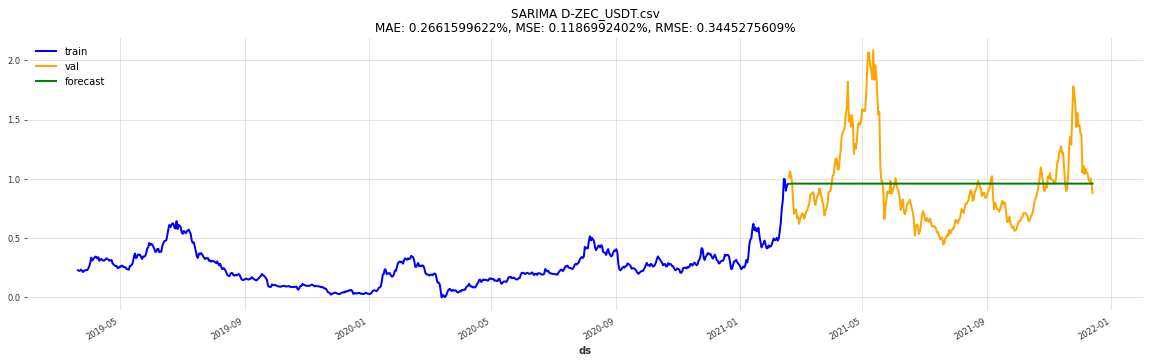

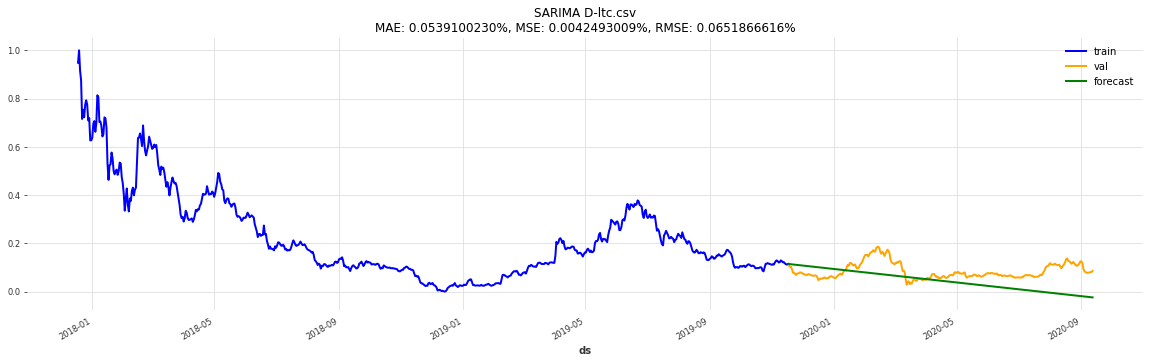

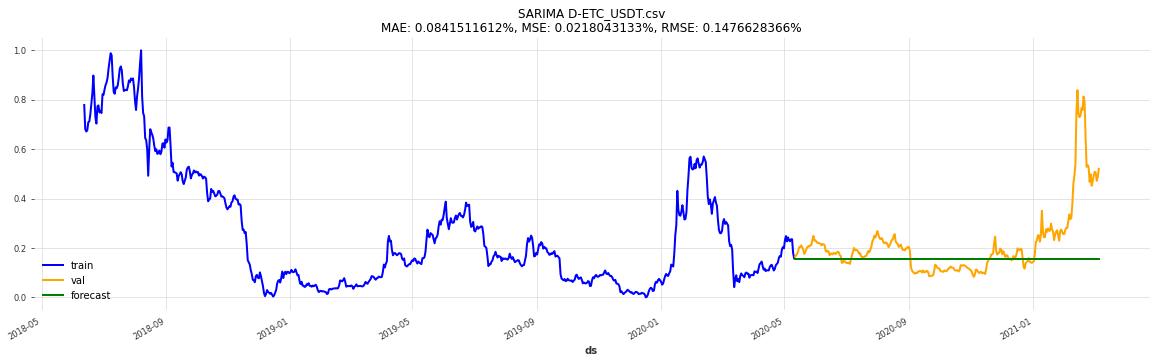

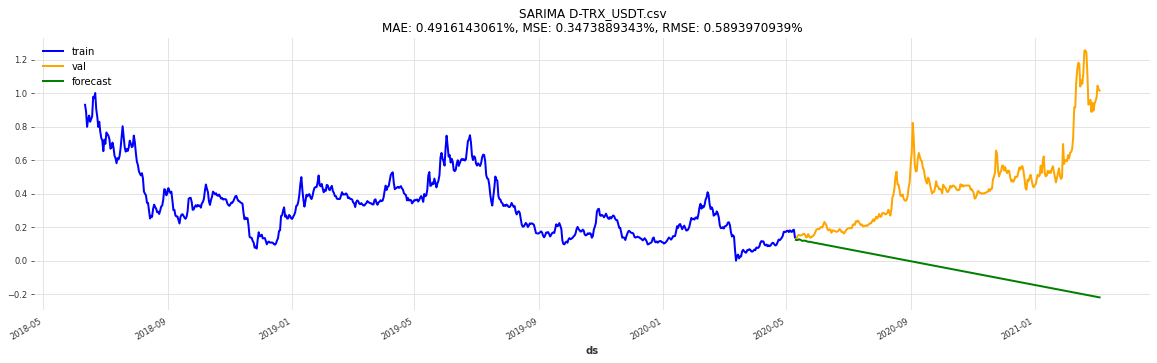

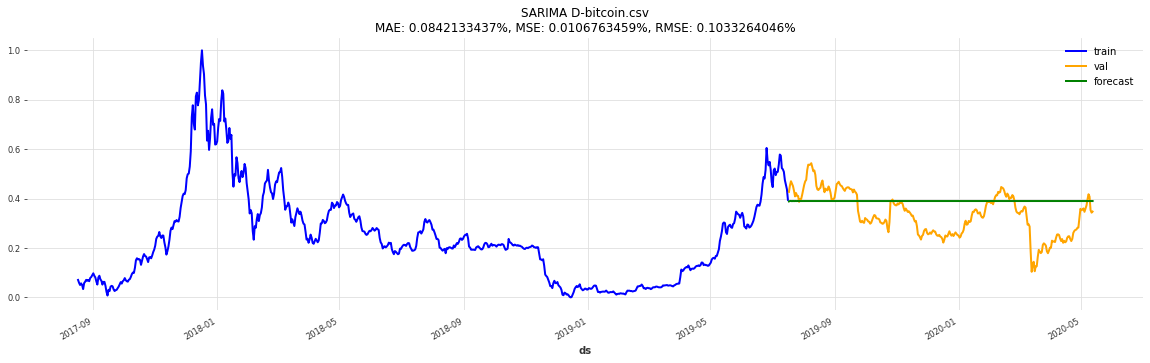

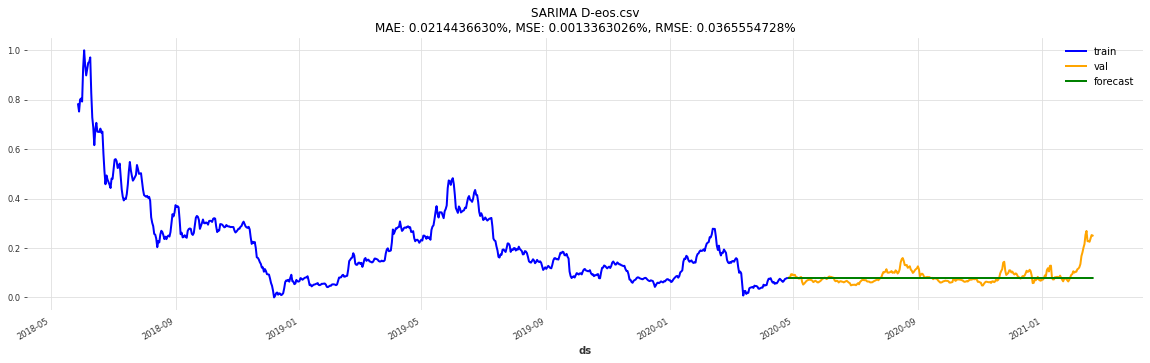

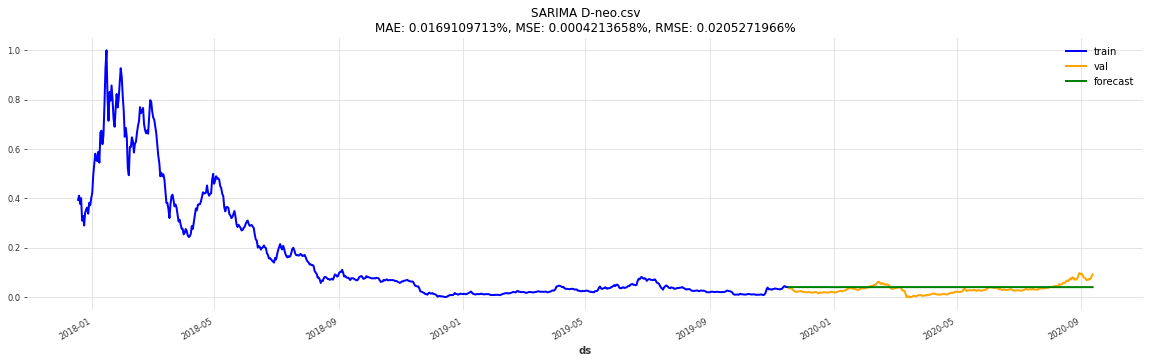

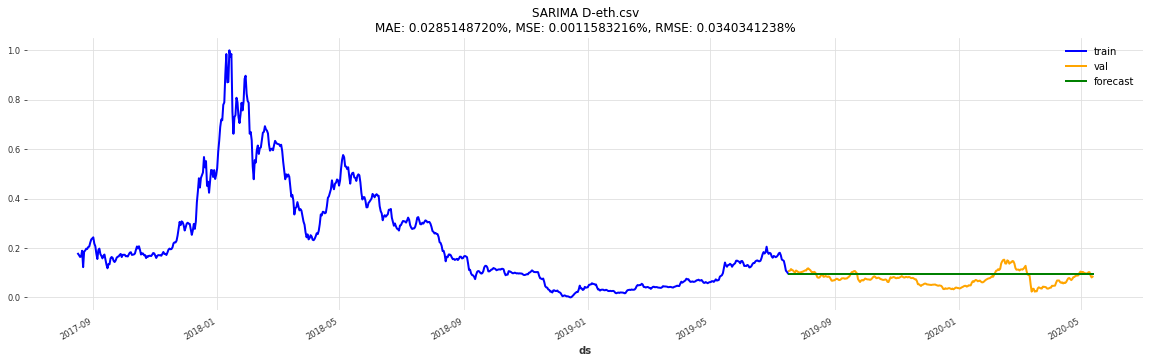

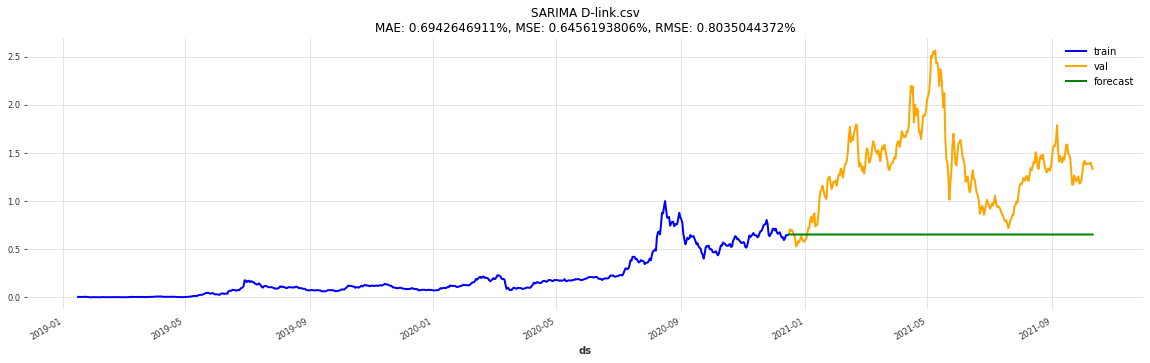

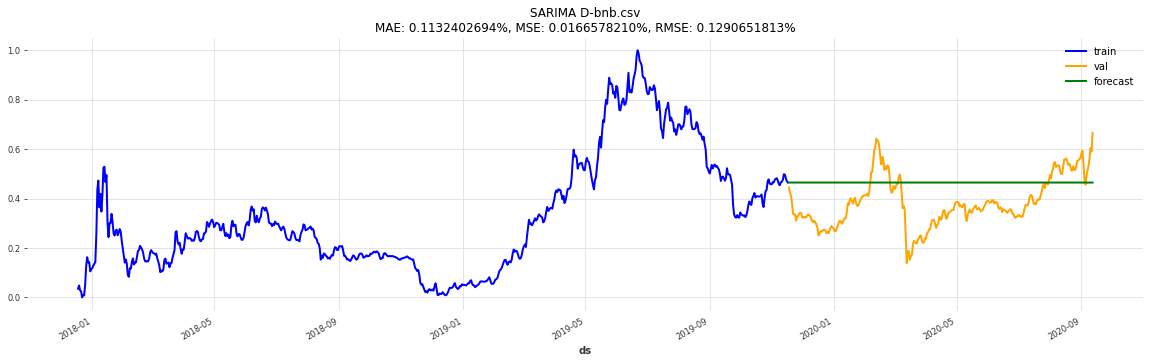

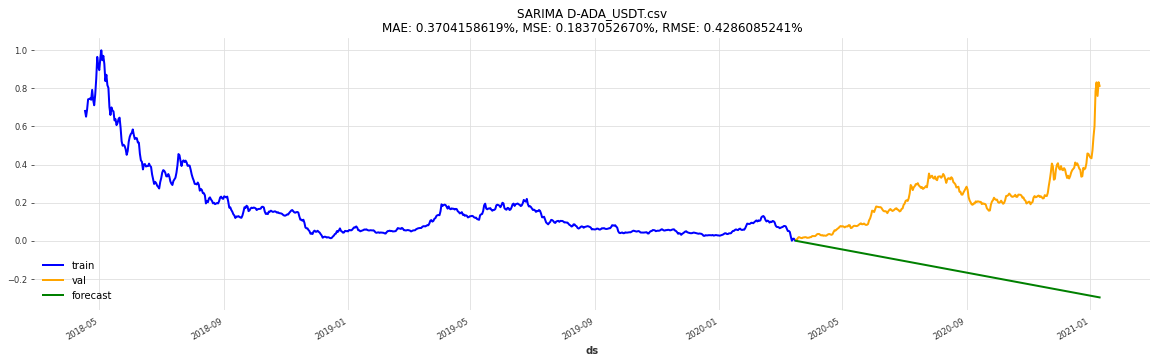

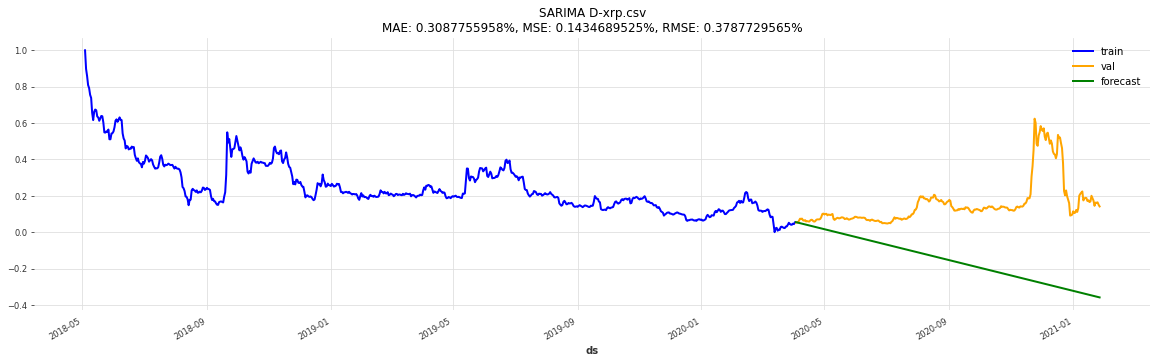

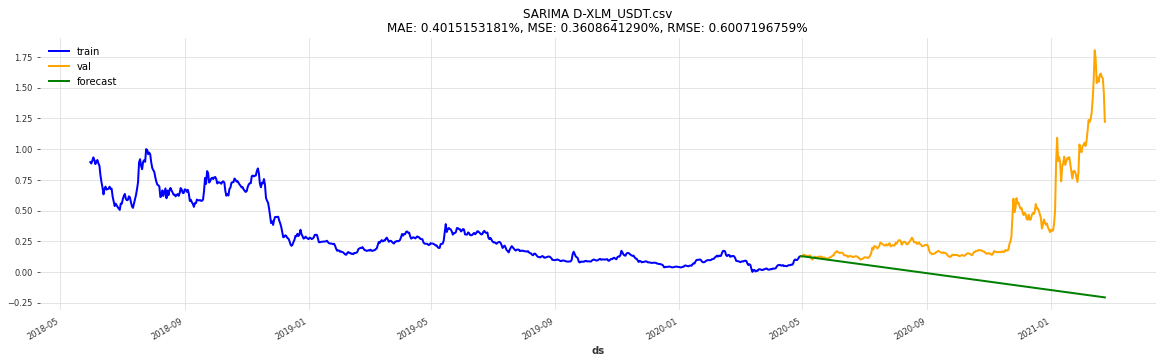

In [14]:
for i in range(len(df)):
    plt.figure(figsize=(20,5))
    train, val = series_scaled_list[i][:-300], series_scaled_list[i][-300:]
    train.plot(color ='blue', label="train")
    val.plot(color ='orange', label="val")
    pred_series_list[i].plot(color ='green',label="forecast")
    plt.title('SARIMA {}.csv\nMAE: {:.10f}%, MSE: {:.10f}%, RMSE: {:.10f}%'.format(file_name[i],mae(pred_series_list[i], val_scaled_list[i]), mse(pred_series_list[i], val_scaled_list[i]), rmse(pred_series_list[i], val_scaled_list[i])))
    plt.legend(loc='best')
    plt.show()